# Correlate hash abundances after normalization with median of ratios method

In [1]:
setwd("..")

In [2]:
# change default figure size
options(repr.plot.width=15, repr.plot.height=7)
# disable scientific notation (for plot axes)
options(scipen = 999)

In [4]:
library(readr)
library(dplyr)
library(tibble)
library(tidyr)
library(purrr)
library(ggplot2)
library(ggpubr)
library(DESeq2)

## Functions

In [5]:
hlog <- function(df, base=exp(1)){
  # Description: 'safely' tales the log of data replacing -Inf and Nan with 0
  # df: dataframe of gene expression to be logged
  # base: base for log calculation
  # returns: log of df with happy 0s for 0 or neg values
  dfl <- data.frame(log(data.matrix(df),base))
  dfl[dfl == -Inf] <- 0
  dfl[dfl < 0] <- 0
  dfl
}

In [6]:
MRnorm <- function(data){
  # Description: sample-wise median of ratio normalization on columns
  # data: dataframe of gene expression counts to be normalized via DESeq2
  # returns: dataframe normalized to geometric mean of all samples
  meta <- data.frame(experiment = colnames(data))
  dds <- DESeqDataSetFromMatrix(countData = ceiling(data),
                                colData = meta,
                                design = ~ experiment)
  dds <- estimateSizeFactors(dds)
  counts(dds, normalized=TRUE)
}

In [7]:
# transform the square correlation matrix into long format
cor_to_long <- function(m){
    #df <- m %>%
    #  as.data.frame %>% 
    #  tibble::rownames_to_column() %>% 
    #  tidyr::pivot_longer(-rowname) %>%
    #  select(row = rowname, col = name, corr = value) %>%
    #  filter(row != col)
    df <- data.frame(row=rownames(m)[row(m)], col=colnames(m)[col(m)], corr=c(m)) %>%
      filter(row != col)
    df <- df %>% 
      mutate(row = as.numeric(row)) %>% # convery minhash back to numeric to perserve joins later
      mutate(col = as.numeric(row))
} 

## Normalize k-mer abundances

In [8]:
# read in wide count dataframe
raw_pa14_kmers <- read_csv("outputs/srx_sourmash_sketch_wide_csv/pa14_k21.csv", show_col_types = F) %>%
  column_to_rownames("minhash")

Warning message:
“One or more parsing issues, see `problems()` for details”


In [9]:
# add a pseudocount; otherwise normalization will fail bc every k-mer has at least one zero across samples
raw_pa14_kmers_pseudo <- raw_pa14_kmers + 1 

In [10]:
# make a presence absense DF to filter to common k-mers
raw_pa14_kmers_pa <- raw_pa14_kmers %>%
  mutate_if(is.numeric, ~1 * (. != 0))

In [11]:
# filter to common k-mers
# try and keep as many as possible for normalization (i think)
keep_kmers <- rownames(raw_pa14_kmers_pa)[rowSums(raw_pa14_kmers_pa) > 10]
raw_pa14_kmers_filt <- raw_pa14_kmers_pseudo %>%
  rownames_to_column("minhash") %>%
  filter(minhash %in% keep_kmers) %>%
  column_to_rownames("minhash")

In [12]:
# normalize
mrnorm_pa14_kmers <- raw_pa14_kmers_filt %>%
  MRnorm() %>%
  as.data.frame() %>%
  rownames_to_column("minhash")

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [12]:
# write normalized df to file
write_csv(mrnorm_pa14_kmers, "sandbox/202203_normalize/pa14_mrnorm_kmers.csv")

## Read in hash map and label with operons

In [13]:
pa14_hash_map <- read_csv("outputs/txomes_sourmash_sketch_singleton/pa14.csv", show_col_types = F)

In [14]:
pa14_operons <- read_csv("https://raw.githubusercontent.com/greenelab/core-accessory-interactome/master/data/metadata/PA14-operons-2021-07-19.csv", show_col_types = F)

In [15]:
pa14_transcript_to_gene <- read_csv("https://osf.io/ema5c/download", skip = 1, col_names = c("tmp", "transcript_name", "locus_tag"), show_col_types = F) %>%
  select(-tmp)

In [16]:
pa14_hash_map <- pa14_hash_map %>%
  mutate(transcript_name = gsub(" .*", "", name)) %>%
  left_join(pa14_transcript_to_gene, by = "transcript_name") %>%
  left_join(pa14_operons, by = "locus_tag")

In [17]:
pa14_hash_map_operon <- pa14_hash_map %>%
  filter(!is.na(`operon-id`))

pa14_hash_map_operon_small <- pa14_hash_map_operon %>%
  select(minhash, operon_id = `operon-id`) %>%
  distinct()

## Filter our "rare" k-mers

DESeq2 normalization was done with minimal filtering, keeping all k-mers that were in at least 10 data sets. 
Further filter out "rare" k-mers so that corelations can be performed without exhausting vector memory.

In [18]:
# define a vector of kmers to keep; limit to ones that are present in many samples
keep_kmers <- rownames(raw_pa14_kmers_pa)[rowSums(raw_pa14_kmers_pa) > 50]

length(keep_kmers)

[1] 10402

## Correlations with normalized hashes

### Normalized hashes

In [19]:
# can start nb from here by reading in file
# mrnorm_pa14_kmers <- read_csv("sandbox/202203_normalize/pa14_mrnorm_kmers.csv", show_col_types = F)

In [20]:
# do correlation analysis
tmp <- mrnorm_pa14_kmers %>%
  filter(minhash %in% keep_kmers) %>%
  column_to_rownames("minhash") %>%
  t()

mrnorm_pa14_kmers_cor <- cor(tmp, method = "pearson")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



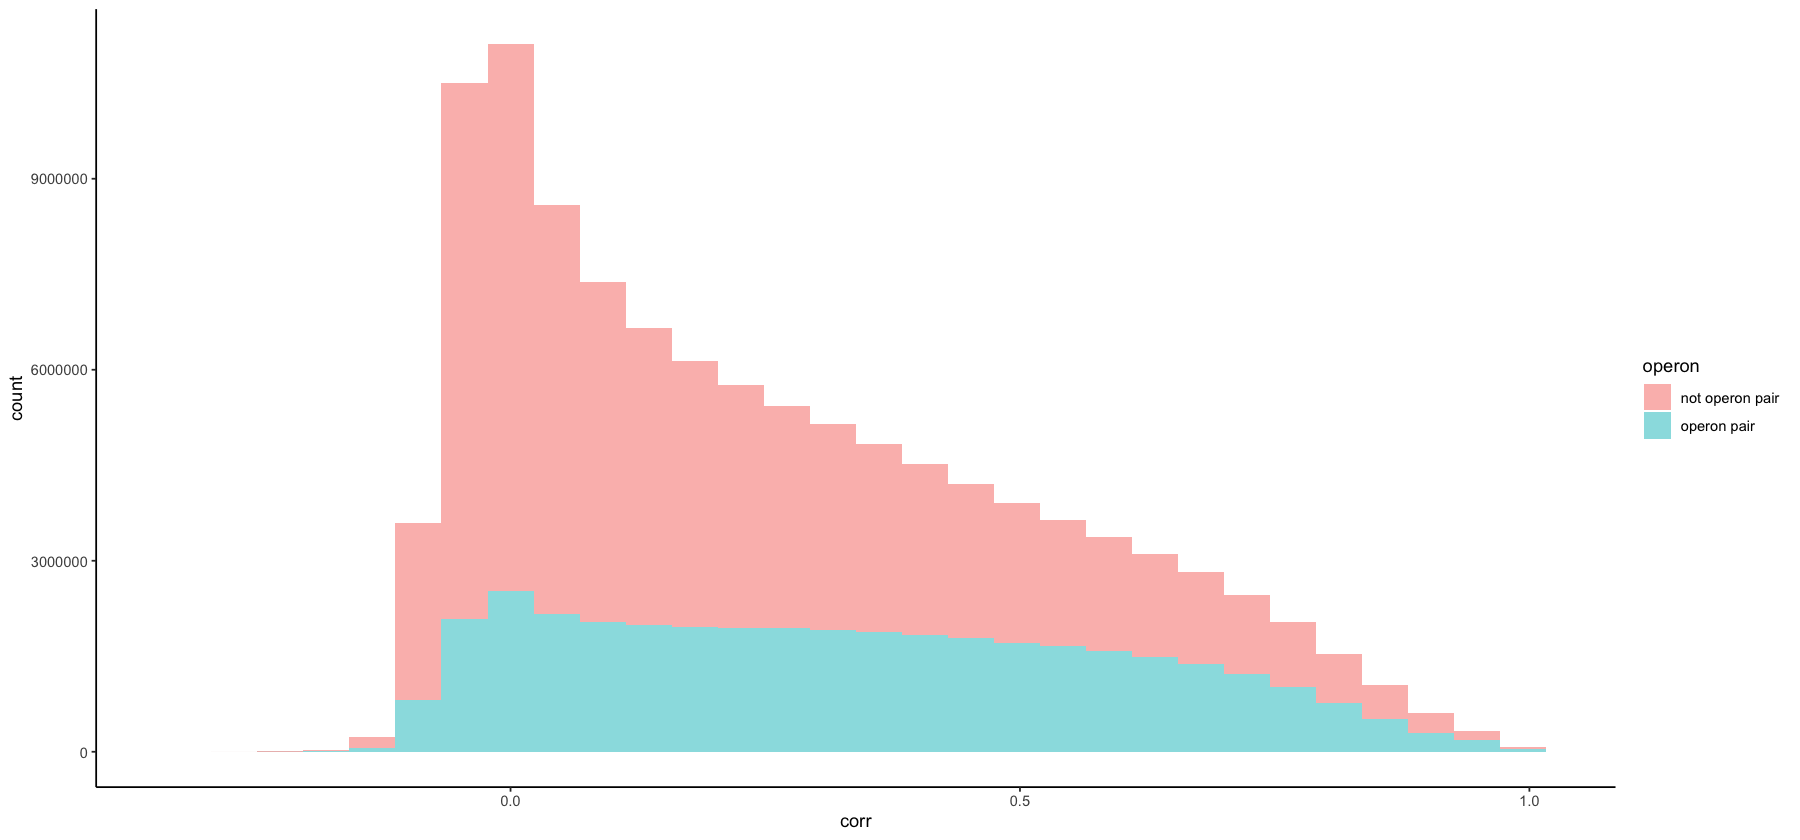

In [21]:
# add operon metadata and plot
mrnorm_pa14_kmers_cor_df <- cor_to_long(mrnorm_pa14_kmers_cor) %>%
  left_join(pa14_hash_map_operon_small, by = c("row" = "minhash")) %>% # determine which operon, if any, the row is part of
  select(row, col, corr, operon_id_row = operon_id) %>% # record operon identity of row
  left_join(pa14_hash_map_operon_small, by = c("col" = "minhash")) %>% # determine which operon the col is part of
  select(row, col, corr, operon_id_row, operon_id_col = operon_id) %>% # record operon identity of col
  mutate(operon = ifelse(operon_id_row == operon_id_col, "operon pair", "not operon pair")) %>% # label operon pairs
  mutate(operon = ifelse(is.na(operon), "not operon pair", operon))

ggplot(mrnorm_pa14_kmers_cor_df, aes(x = corr, fill = operon)) +
  geom_histogram(alpha = .5) +
  theme_classic()

### log of normalized hashes

In [19]:
# do log norm correlation analysis
tmp <- mrnorm_pa14_kmers %>%
  filter(minhash %in% keep_kmers) %>%
  column_to_rownames("minhash") %>%
  hlog() %>%
  t()

mrnorm_hlog_pa14_kmers_cor <- cor(tmp, method = "pearson")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



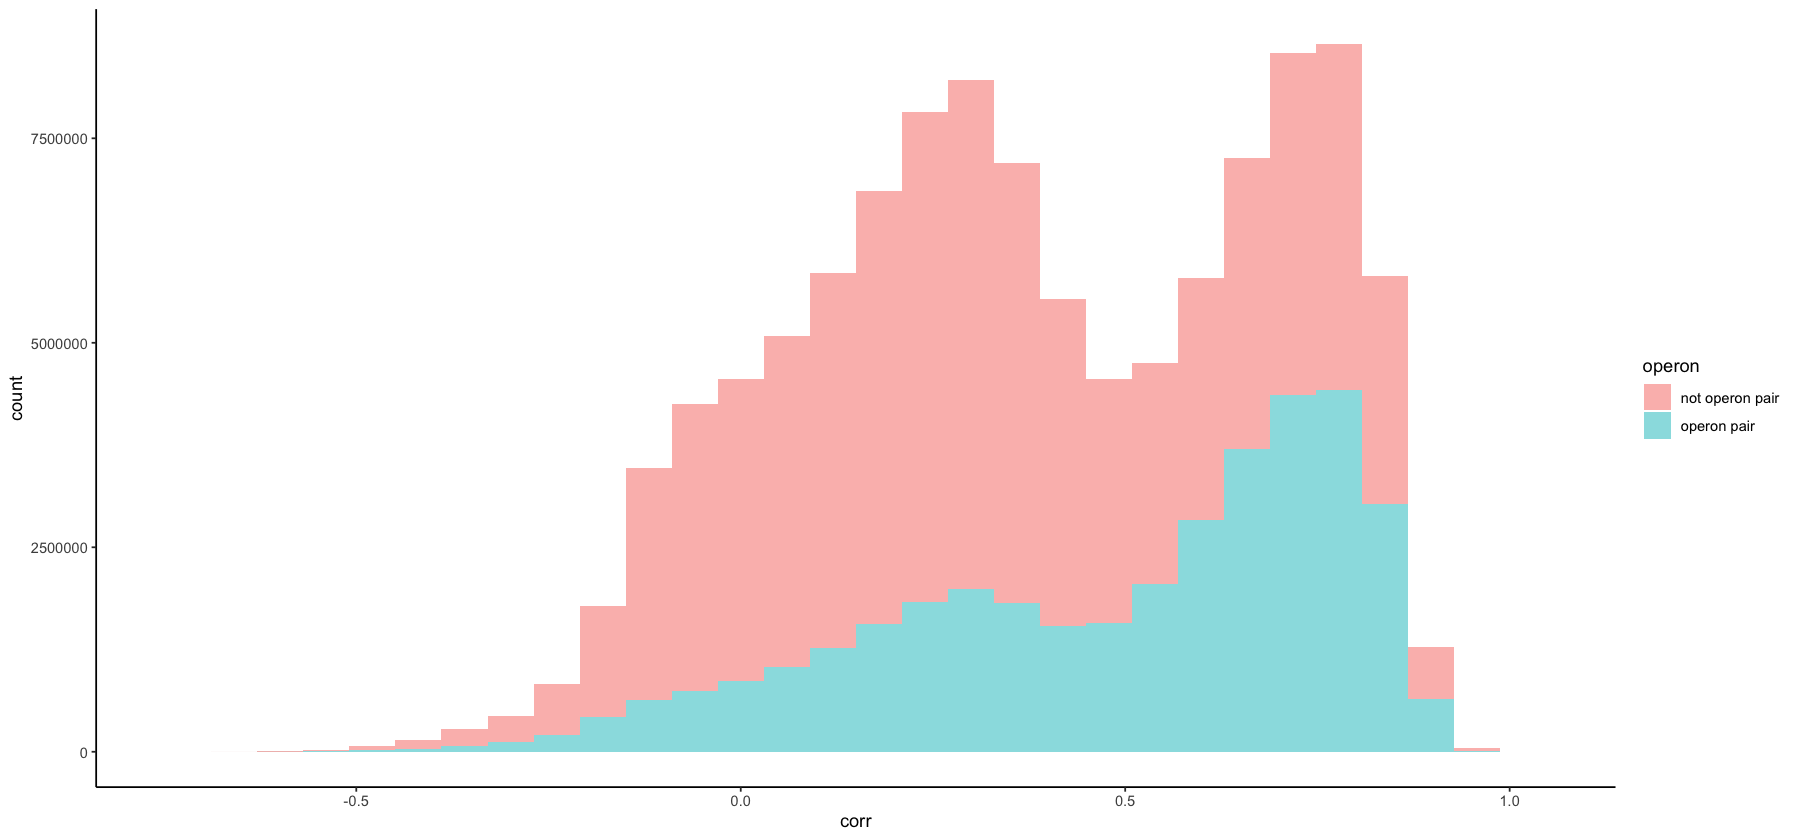

In [20]:
mrnorm_hlog_pa14_kmers_cor_df <- cor_to_long(mrnorm_hlog_pa14_kmers_cor) %>%
  left_join(pa14_hash_map_operon_small, by = c("row" = "minhash")) %>% # determine which operon, if any, the row is part of
  select(row, col, corr, operon_id_row = operon_id) %>% # record operon identity of row
  left_join(pa14_hash_map_operon_small, by = c("col" = "minhash")) %>% # determine which operon the col is part of
  select(row, col, corr, operon_id_row, operon_id_col = operon_id) %>% # record operon identity of col
  mutate(operon = ifelse(operon_id_row == operon_id_col, "operon pair", "not operon pair")) %>% # label operon pairs
  mutate(operon = ifelse(is.na(operon), "not operon pair", operon))

ggplot(mrnorm_hlog_pa14_kmers_cor_df, aes(x = corr, fill = operon)) +
  geom_histogram(alpha = .5) +
  theme_classic()